<a href="https://colab.research.google.com/github/jktb/DEEP--Tech-123/blob/main/DTTE_Tutorial_28_Applying_Bayes_Classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Machine Learning: Lab 3 - Applying Bayes Classifiers

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/1TuDbIyso6irdyBFgaHRpC-PxUICWPHcS?usp=sharing"><img height="32px" src="https://colab.research.google.com/img/colab_favicon.ico" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/Foundations-in-Modern-Machine-Learning/course-contents/tree/main/Bayesian/"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>
<br>
<br>
<br>

In [1]:
import os
import json
import re

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as pg

import tensorflow as tf
import tensorflow_probability as tfp

In [2]:
!wget https://raw.githubusercontent.com/Foundations-in-Modern-Machine-Learning/course-contents/main/Bayesian/data/arxiv-paper-data.json
plt.style.use('ggplot')

--2023-10-12 10:51:30--  https://raw.githubusercontent.com/Foundations-in-Modern-Machine-Learning/course-contents/main/Bayesian/data/arxiv-paper-data.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72422946 (69M) [text/plain]
Saving to: ‘arxiv-paper-data.json’

arxiv-paper-data.js 100%[===================>]  69.07M   121MB/s    in 0.6s    

2023-10-12 10:51:41 (121 MB/s) - ‘arxiv-paper-data.json’ saved [72422946/72422946]



Let's make a few assumptions to come up with our first general model for classification:
* The different features contribute equally to the result
* The features are independent

## Bayes Classifiers in Scikit Learn

### Simple 1-D Classfication using Naive Bayes in Continuous Space

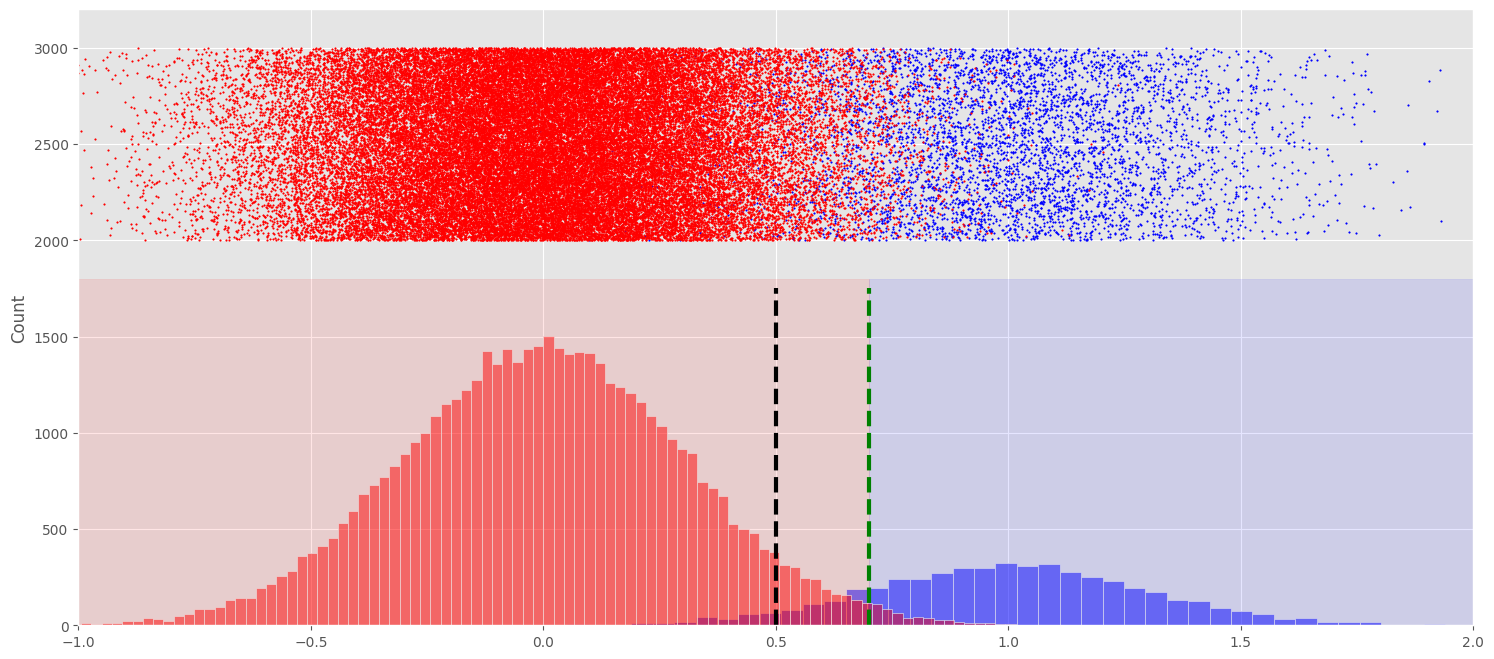

In [3]:
fig, ax = plt.subplots(figsize=(18, 8))
x1 = np.random.normal(1.0, 0.3, size=5000)
x2 = np.random.normal(0.0, 0.3, size=50000)
x = np.concatenate([x1, x2])
y = np.concatenate([np.zeros(len(x1)), np.ones(len(x2))])
sns.histplot(x1, color='blue', alpha=0.5, ax=ax)
sns.histplot(x2, color='red', alpha=0.5, ax=ax)
ax.fill_between(np.linspace(-1.0, 0.7, 100), 0, 1800,  color='r', alpha=0.1)
ax.fill_between(np.linspace(0.7, 2.0, 100), 0, 1800,  color='b', alpha=0.1)
ax.vlines(0.5, 0, 1750, color="k", linestyles="--", lw=3)
ax.vlines(0.7, 0, 1750, color="g", linestyles="--", lw=3)
ax.scatter(x1, [np.random.randint(2000, 3000) for _ in x1], color='b', s=1)
ax.scatter(x2, [np.random.randint(2000, 3000) for _ in x2], color='r', s=1)
ax.set_xlim(-1.0, 2.0)
ax.set_ylim(0, 3200)
plt.show()

In [4]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
x_reshaped = x.reshape(1, -1)
print(x_reshaped.shape)

(1, 55000)


## Gaussian Bayes Predictor on Predicting Flowers

### Predictors in Scikit Learn

In [5]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

X, y = load_iris(return_X_y=True)
X = X[:, [2, 3]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

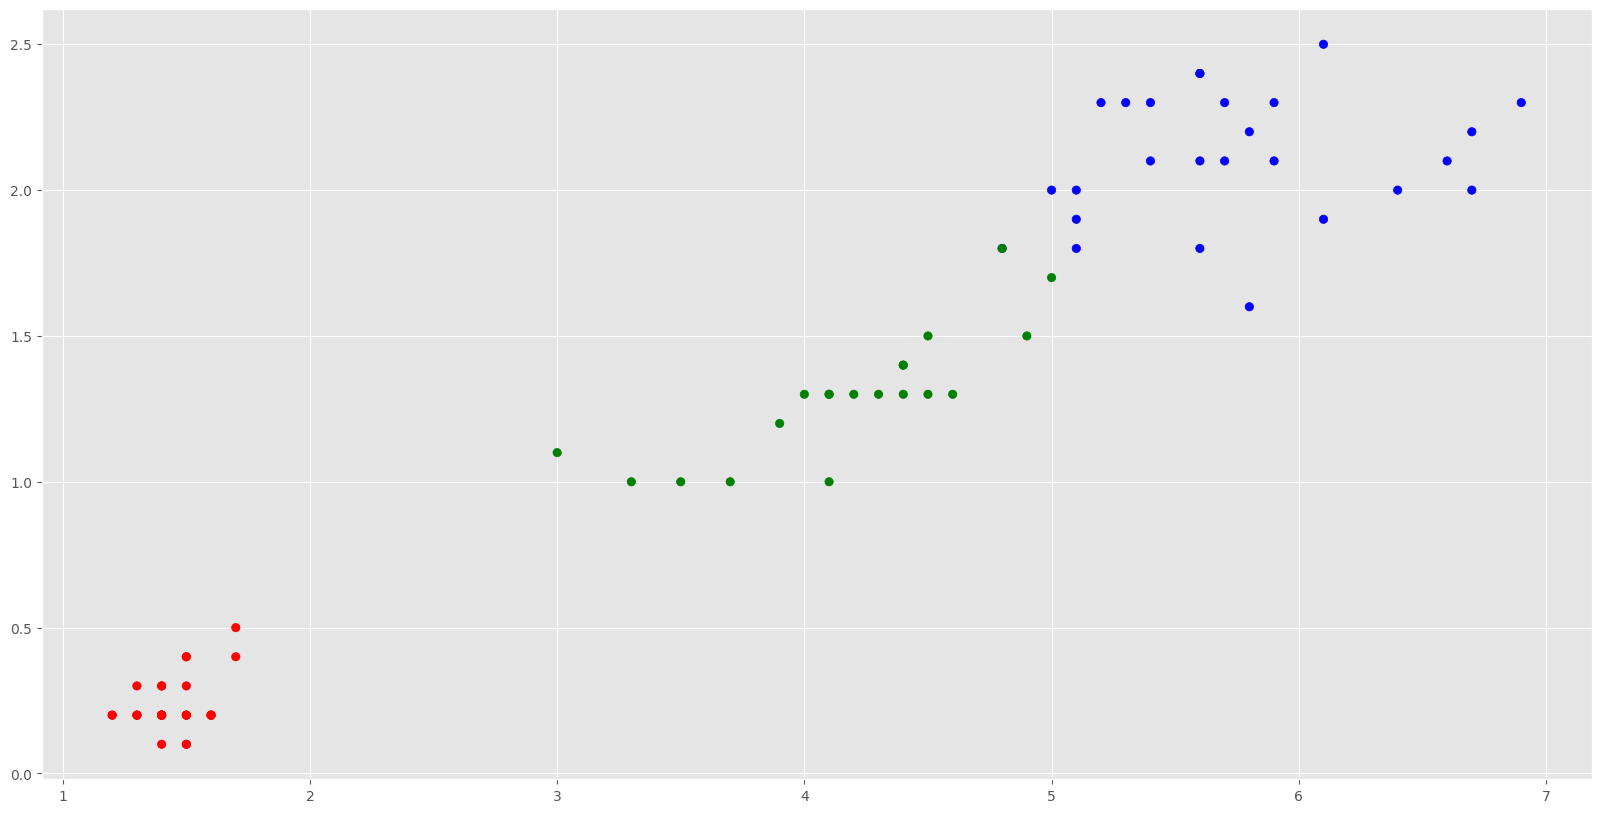

In [6]:
plt.figure(figsize=(20, 10))
color_scheme = ['red', 'green', 'blue']
plt.scatter(X_train[:, 0], X_train[:, 1], c=[color_scheme[idx] for idx in y_train])
plt.show()

### Visualizing the Decision Surface

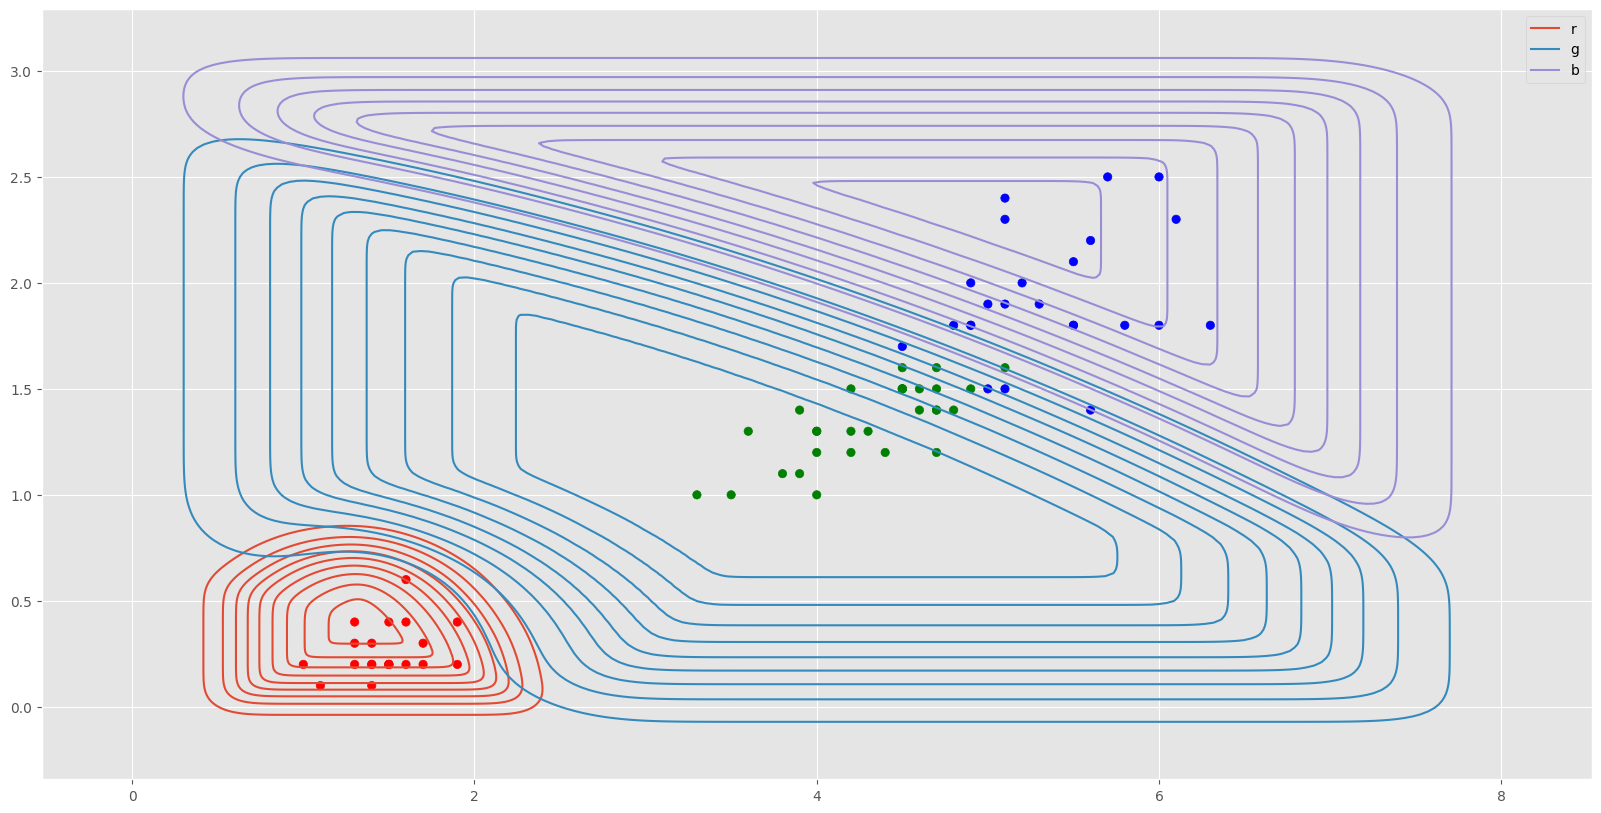

In [7]:
plt.figure(figsize=(20, 10))
X1_scan, X2_scan = np.meshgrid(np.linspace(0.5, 7.5, 250), np.linspace(0.0, 3.0, 250))
X_scan = np.stack([np.reshape(X1_scan, -1), np.reshape(X2_scan, -1)], axis=-1)
predictions = gnb.predict(X_scan)
color_map = ['r', 'g', 'b']
plt.scatter(x=X_test[:, 0], y=X_test[:, 1], c=[color_map[x] for x in y_test])
sns.kdeplot(x=X_scan[:, 0], y=X_scan[:, 1], hue=[color_map[x] for x in predictions], fill=False)
plt.show()

## Bayes on Text - Classifying papers at Arxiv

### Data Cleaning and Preprocessing

In [8]:
arxiv_df = pd.read_json(open("arxiv-paper-data.json", 'r'))
arxiv_df["tag"] = arxiv_df["tag"].apply(lambda x: json.loads(x.replace("\'", "\"").replace("None", "\"None\""))[0]['term'].split('.')[0])
arxiv_df["tag"] = arxiv_df["tag"].apply(lambda x: 'physics' if x in ['physics', 'quant-ph', 'astro-ph', 'hep-ex', 'hep-ph', 'hep-lat', 'hep-th', 'nucl-th'] else x)
arxiv_df = arxiv_df.drop(["day", "month", "link", "author"], axis=1)

In [9]:
SAMPLES_COMP = 3500 #@param {type: "slider", min: 1000, max: 4500}
SAMPLES_STAT = 2500 #@param {type: "slider", min: 1000, max: 4500}
WORD_COUNT_THRESHOLD = 1  #@param {type: "slider", min: 1, max: 500}
WORD_LENGTH_THRESHOLD = 8  #@param {type: "slider", min: 4, max: 20}

In [10]:
df = pd.concat([arxiv_df[arxiv_df['tag'] == 'cs'].sample(SAMPLES_COMP, replace=False),
                arxiv_df[arxiv_df['tag'] == 'stat'].sample(SAMPLES_STAT, replace=False)]).sample(frac=1)
df['keywords'] = df.apply(lambda x: [word.lower() for word in re.sub('[^(\w| )]', '', re.sub('(-|_|\n)', ' ', x.summary + ' ' + x.title)).split()
                                     if len(word) > WORD_LENGTH_THRESHOLD and not re.search('(\d|\(|\))', word)], axis=1)
train_df, test_df = df.iloc[:int(len(df) * 0.8)], df.iloc[int(len(df) * 0.8):]

train_df

,id,summary,tag,title,year,keywords
11097,1407.0316v3,The problem of finding itemsets that are stati...,stat,Significant Subgraph Mining with Multiple Test...,2014,"[statistically, significantly, transactions, c..."
13416,1209.0167v3,Background: In recent years automated data ana...,cs,Automatic ECG Beat Arrhythmia Detection,2012,"[background, automated, techniques, attention,..."
19238,1304.2718v1,Dempster's rule of combination has been the mo...,cs,Can Evidence Be Combined in the Dempster-Shafe...,2013,"[dempsters, combination, controversial, partic..."
12921,1711.05825v2,Approximate Bayesian computation (ABC) and syn...,stat,Bootstrapped synthetic likelihood,2017,"[approximate, computation, synthetic, likeliho..."
16066,1609.02846v1,Spoken dialogue systems allow humans to intera...,cs,Dialogue manager domain adaptation using Gauss...,2016,"[communication, interface, facilitate, acquisi..."
...,...,...,...,...,...,...
10011,1606.08362v1,A function $f: \mathbb{Z}_+^E \rightarrow \mat...,cs,A Reduction for Optimizing Lattice Submodular ...,2016,"[rightarrow, submodular, satisfies, maximizing..."
7336,1711.10781v1,Tensors are multidimensional arrays of numeric...,stat,Introduction to Tensor Decompositions and thei...,2017,"[multidimensional, numerical, therefore, gener..."
36149,1207.1392v1,Consider the case where cause-effect relations...,stat,The Graphical Identification for Total Effects...,2012,"[relationships, variables, described, correspo..."
35554,0902.3648v1,We present the first formal algebraic specific...,cs,An Algebraic Dexter-Based Hypertext Reference ...,2009,"[algebraic, specification, hypertext, referenc..."


In [11]:
df['keywords']

11097    [statistically, significantly, transactions, c...
13416    [background, automated, techniques, attention,...
19238    [dempsters, combination, controversial, partic...
12921    [approximate, computation, synthetic, likeliho...
16066    [communication, interface, facilitate, acquisi...
                               ...                        
17387    [supervision, extraction, heuristically, knowl...
27444    [sighthounds, automated, detection, recognitio...
23063    [practical, extensions, optimization, objectiv...
22421    [ensembles, prediction, performance, interpret...
28816    [convolutional, established, achieving, classi...
Name: keywords, Length: 6000, dtype: object

### Learning Probability Distributions

In [12]:
from collections import defaultdict
dictionary = defaultdict(lambda: [0, 0])
for desc, tag in zip(df['keywords'], df['tag']):
    for word in set(desc):
        if tag == 'cs':
            dictionary[word][0] += 1
        else:
            dictionary[word][1] += 1

print("We have a dictionary of", len(dictionary), "words.")

words, counts_cs, counts_stat = [], [], []
for word, count in dictionary.items():
    if count[0] + count[1] > WORD_COUNT_THRESHOLD:
        words.append(word)
        counts_cs.append(count[0])
        counts_stat.append(count[1])
print("Out of those", len(words), f"have over {WORD_COUNT_THRESHOLD} occurances")

fig = pg.Figure([pg.Bar(x=words[:200], y=counts_cs[:200]),
                 pg.Bar(x=words[:200], y=counts_stat[:200])])
fig.update_layout(title_text=f'Some random words and the frequency plot of those with over {WORD_COUNT_THRESHOLD} occurances')
fig.show()

We have a dictionary of 8889 words.
Out of those 4630 have over 1 occurances


For each word, for both the subjects, we can apply Bayes rule.

$$P\bigg(\frac{\text{subject}}{\text{word}}\bigg) = P\bigg(\frac{\text{word}}{\text{subject}}\bigg) \times \frac{P(\text{subject})}{P(\text{word})}$$

### Computing the resultant probabilities

In [13]:
prior = np.array([train_df["tag"].value_counts()["cs"], train_df["tag"].value_counts()["stat"]]) / len(train_df)
evidence = np.array([counts_cs / train_df["tag"].value_counts()["cs"], counts_stat / train_df["tag"].value_counts()["stat"]]).T
likelihood = (np.array(counts_cs) + np.array(counts_stat)) / len(train_df)

prior.shape, likelihood.shape, evidence.shape

((2,), (4630,), (4630, 2))

In [14]:
words_to_index = defaultdict(lambda: -1)
for idx, word in enumerate(words):
    words_to_index[word] = idx

correct, total = 0, 0

answers = []
for tag, keywords in zip(test_df["tag"], test_df["keywords"]):
    this_counts = np.zeros(len(words))
    for word in keywords:
        idx = words_to_index[word]
        if idx != -1:
            this_counts[idx] = 1

    marginal = np.multiply(prior.T, np.divide(
        np.multiply(this_counts.reshape(-1, 1), evidence), likelihood.reshape(-1, 1))) + 0.001
    joint = np.sum(np.log(marginal), axis=0)
    predicted = 'cs' if joint[0] > joint[1] else 'stat'
    answers.append(predicted)
    if predicted == tag:
        correct += 1
    total += 1
test_df.insert(1, "predictions", answers, True)

print("Accuracy:", correct / total)

Accuracy: 0.8175


### Visualizing a few examples

In [15]:
def explain(example):
    from IPython.display import HTML
    title, desc, answer = example["title"], example["summary"], example["tag"]
    html = ""
    title = re.sub(' +', ' ', re.sub('[^(\w| )]', '', re.sub('(-|_|\n)', ' ', title)))
    desc = re.sub(' +', ' ', re.sub('[^(\w| )]', '', re.sub('(-|_|\n)', ' ', desc)))
    for text in [title, desc]:
        for word in text.split():
            idx = words_to_index[word.lower()]
            if idx == -1:
                html += f"<span style=''>{word}</span> "
            else:
                posterior = np.multiply(evidence[idx], prior)
                posterior /= np.sum(posterior)
                if posterior[0] > posterior[1] if answer == 'cs' else (posterior[0] <= posterior[1]):
                    color = max(0.3, posterior[0] - posterior[1])
                    html += f"<span style='background-color:rgba(0, 255, 0, {color});'>{word}</span> "
                else:
                    color = max(0.3, posterior[1] - posterior[0])
                    html += f"<span style='background-color:rgba(255, 0, 0, {color});'>{word}</span> "
        html += "<br/><br/>"
    return HTML(html)

In [16]:
x = test_df[np.logical_and(test_df["predictions"] == test_df["tag"], test_df["tag"] == "cs")].iloc[0]
explain(x)

In [17]:
x = test_df[np.logical_and(test_df["predictions"] == test_df["tag"], test_df["tag"] == "stat")].iloc[0]
explain(x)

In [18]:
x = test_df[np.logical_and(test_df["predictions"] != test_df["tag"], test_df["tag"] == "cs")].iloc[0]
explain(x)

In [19]:
x = test_df[np.logical_and(test_df["predictions"] != test_df["tag"], test_df["tag"] == "stat")].iloc[0]
explain(x)

### Visualizing the Learnt Words

In [20]:
print("Some Computer Science words are:")
for word_cs in np.argsort(evidence[:, 0] - evidence[:, 1])[-10:]:
    print(f"\t{words[word_cs]} ({evidence[word_cs, 0]})")
print()
print("Some Statistics words are:")
for word_st in np.argsort(evidence[:, 1] - evidence[:, 0])[-10:]:
    print(f"\t{words[word_st]} ({evidence[word_st, 1]})")

Some Computer Science words are:
	segmentation (0.06721194879089616)
	evaluation (0.10028449502133713)
	representation (0.13620199146514936)
	processing (0.10953058321479374)
	experimental (0.14046941678520625)
	information (0.25177809388335703)
	detection (0.12339971550497866)
	different (0.27311522048364156)
	recognition (0.12802275960170698)
	convolutional (0.13975817923186346)

Some Statistics words are:
	optimization (0.19064386317907445)
	variables (0.13832997987927564)
	estimation (0.1659959758551308)
	theoretical (0.15492957746478872)
	distribution (0.1795774647887324)
	statistical (0.1574446680080483)
	algorithm (0.3843058350100604)
	dimensional (0.1805835010060362)
	inference (0.19919517102615694)
	regression (0.1805835010060362)


## Probability Smoothing

Probability smoothing is a language modeling technique that assigns some non-zero probability to events that were unseen in the training data. This has the effect that the probability mass is divided over more events, hence the probability distribution becomes more smooth.

### Realizing the Problem

In [21]:
posterior = np.multiply(np.divide(evidence, np.reshape(likelihood, (-1, 1))), np.reshape(prior, (1, -1)))

fig = pg.Figure([pg.Bar(x=words, y=evidence[:20, 0]),
                 pg.Bar(x=words, y=posterior[:20, 0])])
fig.update_layout(title_text='Evidence and Posterior for each word')
fig.show()

In [22]:
print("Some words which never appear in Computer Science paper:\n\t" + "\n\t".join([words[idx] for idx in np.where(np.array(counts_cs) == 0)[0][:20]]))
print("Some words which never appear in Statistics papers:\n\t" + "\n\t".join([words[idx] for idx in np.where(np.array(counts_stat) == 0)[0][:20]]))

Some words which never appear in Computer Science paper:
	transactions
	bootstrapped
	subsamples
	bootstraps
	hypernetworks
	reciprocity
	criterions
	macroeconomic
	metabolite
	mechanistic
	trainability
	geosciences
	parametrically
	normalizer
	attrition
	misspecification
	inflation
	forecasters
	retrospective
	datapoints
Some words which never appear in Statistics papers:
	dempsters
	assistants
	adaptable
	distracted
	distraction
	abstractive
	connectionist
	cooperation
	deforming
	negations
	vagueness
	greediness
	defeasible
	motivational
	rationale
	formalisation
	possibilistic
	utilities
	formalisms
	backtrack


Notice the fact that there are cases where the Evidence $P\big(\frac{\text{word}}{\text{subject}}\big) \rightarrow 0$. This is because there are occurances of the given word in the corpus (all the abstract of papers put together) of that subject.

However, this is no way implies that if a word (eg. Employment) never occurs in our training corpus in a Computer Science paper, it will also never occur in a paper in the test set.

Therefore, setting $P(\text{word} | \text{subject}) = 0$ is incorrect, since it will make the posterior $P(\text{subject} | \text{word}) = 0$, even if the corresponding count it 0, we need to come up with a smoother formulation of the Evidence variables.

### Laplace Smoothing



https://towardsdatascience.com/laplace-smoothing-in-na%C3%AFve-bayes-algorithm-9c237a8bdece


3.053435114503817e-05


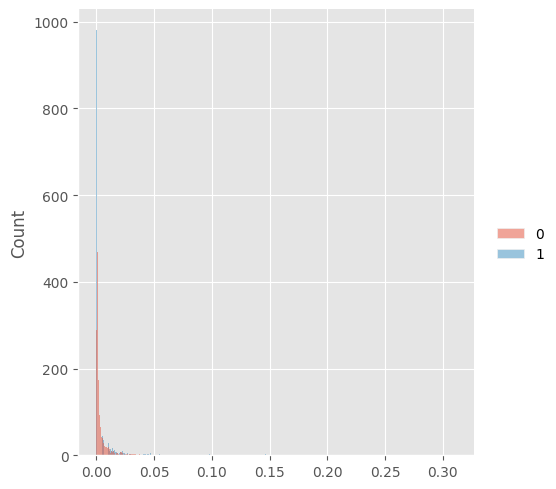

In [23]:
alpha = 0.1
counts_cs, counts_stat = np.array(counts_cs), np.array(counts_stat)
evidence_smooth = np.array([(counts_cs + alpha) / (train_df["tag"].value_counts()["cs"] + alpha * len(words)),
                            (counts_stat + alpha) / (train_df["tag"].value_counts()["stat"] + alpha * len(words))]).T
print(np.min(evidence_smooth))
sns.displot(evidence_smooth)

In [24]:
words_to_index = defaultdict(lambda: -1)
for idx, word in enumerate(words):
    words_to_index[word] = idx

correct, total = 0, 0

answers = []
for tag, keywords in zip(test_df["tag"], test_df["keywords"]):
    this_counts = np.zeros(len(words))
    for word in keywords:
        idx = words_to_index[word]
        if idx != -1:
            this_counts[idx] = 1

    marginal = np.multiply(prior.T, np.divide(np.multiply(this_counts.reshape(-1, 1), evidence_smooth), likelihood.reshape(-1, 1))) + 0.0000001
    joint = np.sum(np.log(marginal), axis=0)
    predicted = 'cs' if joint[0] > joint[1] else 'stat'
    answers.append(predicted)
    if predicted == tag:
        correct += 1
    total += 1
test_df.insert(1, "predictions", answers, True)

print("Accuracy:", correct / total)

Accuracy: 0.7616666666666667


# **Questions**

1. In the "Bayes on Text - Classifying papers at Arxiv" section, what preprocessing steps are performed on the Arxiv paper data? Why are these steps necessary?

2. How are probability distributions learned from the Arxiv paper data, and how are these distributions used in the classification of papers into Computer Science (CS) and Statistics (Stat) categories?

3. What is probability smoothing, and why is it necessary in the context of the Bayesian classifier used in this code? How does Laplace smoothing improve the model's performance, and what parameter is involved in Laplace smoothing?

4. The code uses Laplace smoothing with a fixed value of alpha = 0.1. How might you experiment with different values of alpha to observe the impact on classification accuracy? Provide an example of how you would modify the code to test various alpha values.

5. In the "Visualizing the Decision Surface" section, the code visualizes the decision boundary for the Gaussian Naive Bayes classifier. How would you adjust the code to change the size or color of the decision boundary line, and what significance might these changes have?

**ANSWER-1**


Some physics related categories are mapped to 'physics'.
  
Unwanted columns, are dropped - "day", "month", "link" and "author".

The dataset is sampled to balance the number of samples from the "cs" and "stat" categories.

Data is cleaned by removing non-alphanumeric characters and splitting it into words.


**ANSWER-2**

Probability distributions are learned from the Arxiv paper data as follows:

Conditional probabilities of the word appearing in a "cs" paper or a "stat" paper using Bayes' rule.

Prior probabilities calculated based on the training data.

The evidence probabilities calculated for both categories(considering word's frequency)


**ANSWER-3**

It is a technique used to handle the issue of zero probabilities that can occur in probabilistic models, particularly when dealing with sparse data. In natural language processing (NLP), this is common when estimating probabilities of rare or unseen events based on a limited dataset.


 probability smoothing is necessary to avoid the problem of zero probabilities for certain words or combinations of words. If a word in the test data hasn't been seen in the training data, the unsmoothed model would assign it a probability of zero, which would lead to a prediction of zero probability for the entire class.

 Laplace smoothing, also known as add-one smoothing, is one specific method of probability smoothing. It involves adding a small constant (usually 1) to the count of each possible outcome. This has the effect of "smoothing out" the probability distribution and prevents the estimate from being zero.

Mathematically, if we have a word w and a class c, Laplace smoothing can be expressed as:

P(w∣c)=count(w,c)+1count(c)+VP(w∣c)=count(c)+Vcount(w,c)+1​

where:

count(w,c)count(w,c) is the number of times word ww appears in documents of class cc in the training set.

count(c)count(c) is the total count of all words in class cc in the training set.

VV is the size of the vocabulary (total number of unique words in the training set).

The "+1" in the numerator ensures that even if a word hasn't been seen in a particular class in the training data, it still has a non-zero probability of occurring.

**ANSWER-4**



3.555602331479561e-08
6.8856296908352275e-06
9.752291788570315e-05
0.0001343724805159903


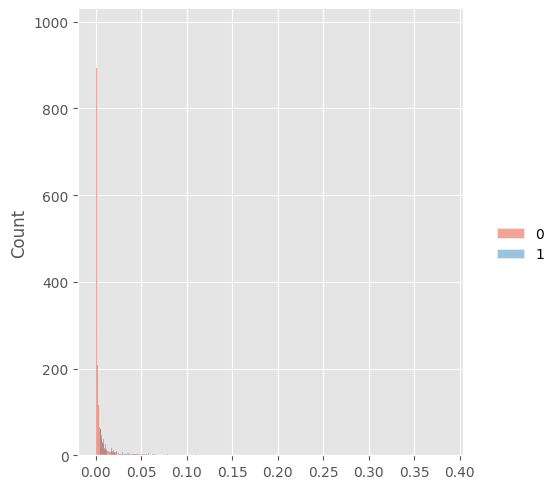

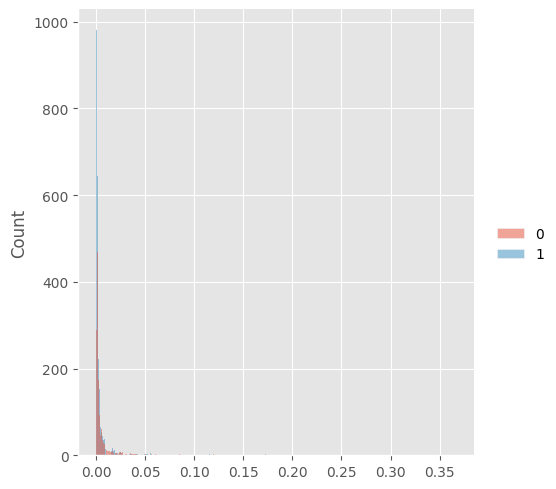

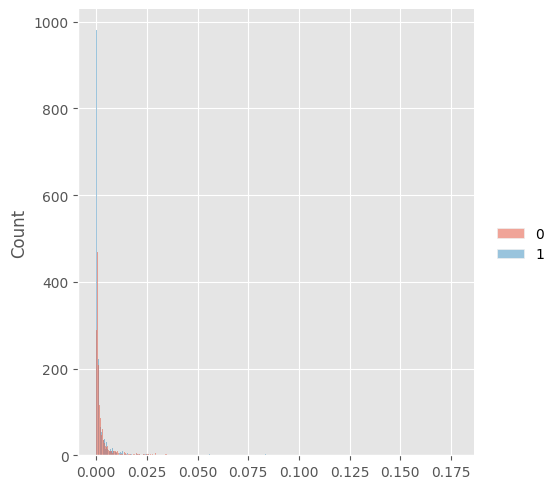

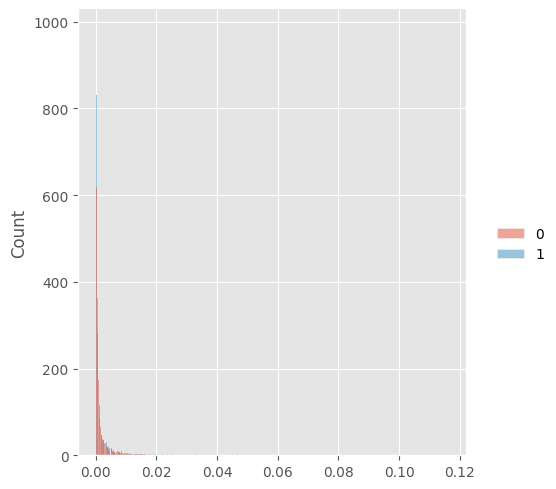

In [26]:
alphas = [0.0001, 0.02,0.5, 1.0]
for alpha in alphas:
  counts_cs, counts_stat = np.array(counts_cs), np.array(counts_stat)
  evidence_smooth = np.array([(counts_cs + alpha) / (train_df["tag"].value_counts()["cs"] + alpha * len(words)),
                              (counts_stat + alpha) / (train_df["tag"].value_counts()["stat"] + alpha * len(words))]).T
  print(np.min(evidence_smooth))
  sns.displot(evidence_smooth)


In [28]:


alphas = [0.0001, 0.01,0.5, 1.0]

accuracy_results = {}

for alpha in alphas:
    counts_cs, counts_stat = np.array(counts_cs), np.array(counts_stat)
    evidence_smooth = np.array([(counts_cs + alpha) / (train_df["tag"].value_counts()["cs"] + alpha * len(words)),
                                (counts_stat + alpha) / (train_df["tag"].value_counts()["stat"] + alpha * len(words))]).T

    correct, total = 0, 0
    answers = []

    for tag, keywords in zip(test_df["tag"], test_df["keywords"]):
        this_counts = np.zeros(len(words))
        for word in keywords:
            idx = words_to_index[word]
            if idx != -1:
                this_counts[idx] = 1

        marginal = np.multiply(prior.T, np.divide(np.multiply(this_counts.reshape(-1, 1), evidence_smooth), likelihood.reshape(-1, 1))) + 0.0000001
        joint = np.sum(np.log(marginal), axis=0)
        predicted = 'cs' if joint[0] > joint[1] else 'stat'
        answers.append(predicted)

        if predicted == tag:
            correct += 1
        total += 1

    accuracy = correct / total

    accuracy_results[alpha] = accuracy

    print(f"Alpha = {alpha}: Accuracy = {accuracy}")



Alpha = 0.0001: Accuracy = 0.8191666666666667
Alpha = 0.01: Accuracy = 0.8125
Alpha = 0.5: Accuracy = 0.6791666666666667
Alpha = 1.0: Accuracy = 0.6341666666666667


ax.vlines(0.5, 0, 1750, color="cyan", linestyles="--", lw=2a)

ax.vlines(0.7, 0, 1750, color="red", linestyles="--", lw=1)

 'color' : Changes the color

 'line width : Adjust width of the line.
